In [3]:
import pandas as pd

In [23]:
df = pd.read_csv("../data/creditcard.csv")

creating synthetic data for streaming to Kafka

In [24]:
import pandas as pd
from sklearn.datasets import make_classification

# Step 2: Separate features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Step 3: Generate synthetic data
n_features = X.shape[1]
n_informative = int(0.6 * n_features)
n_redundant = int(0.2 * n_features)

X_synthetic, y_synthetic = make_classification(
    n_samples=10000,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    weights=[0.995, 0.005],  # Maintain similar class imbalance
    random_state=42
)

# Step 4: Create DataFrame for synthetic data
synthetic_df = pd.DataFrame(X_synthetic, columns=X.columns)
synthetic_df['Class'] = y_synthetic

# Step 5: Combine with the original dataset
combined_df = pd.concat([df, synthetic_df], ignore_index=True)

print(f"Original dataset size: {df.shape}")
print(f"Combined dataset size: {combined_df.shape}")

Original dataset size: (284807, 31)
Combined dataset size: (294807, 31)


In [25]:
synthetic_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.005272,4.075129,-2.764631,1.644818,1.165627,-0.071879,-2.643931,-0.935485,2.558267,0.716198,...,-1.320460,-4.671398,1.167294,1.929147,1.349388,0.253819,4.294589,3.750721,-2.145789,0
1,3.863234,-0.597283,4.036636,-1.282080,-1.575002,2.501795,-0.481181,-0.918403,-2.530954,0.141643,...,7.555955,3.707745,-0.685794,-3.737507,1.605897,1.552166,-0.407718,0.445419,-0.789505,0
2,0.040658,-0.291049,-3.225684,-1.714998,-2.651204,-6.220462,-2.383984,-1.228089,0.371717,-1.302734,...,-0.918258,2.960716,1.215964,-1.355824,4.453476,0.731030,1.486228,0.455704,1.832036,0
3,-1.229750,5.441972,-5.987838,1.058243,2.404318,2.997089,-4.139572,3.030406,-0.821636,0.415745,...,-3.057280,-3.990113,0.687736,0.869378,2.872223,-3.166167,-3.161978,-0.430065,-1.307947,0
4,1.186835,4.171696,2.563339,1.491820,2.314844,2.243018,1.246459,0.213166,-5.635583,1.380369,...,-4.885634,-2.415798,0.313980,-1.827367,-0.909375,3.832963,4.678861,2.478731,-1.798397,0


In [26]:
synthetic_df['Class'].value_counts()

Class
0    9895
1     105
Name: count, dtype: int64

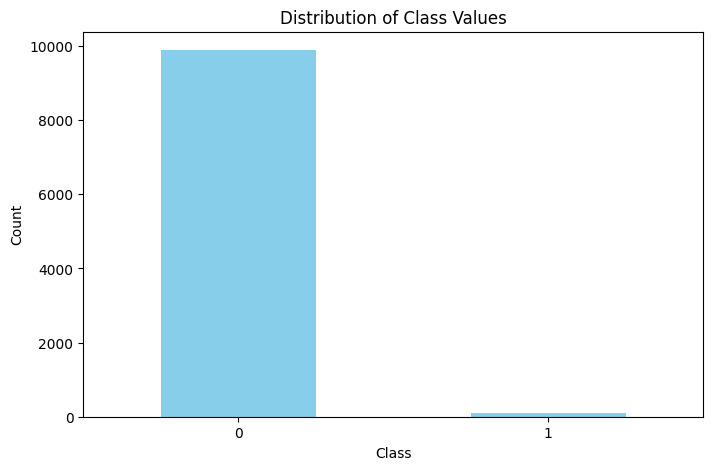

In [27]:
import matplotlib.pyplot as plt

# Generate value counts
class_counts = synthetic_df['Class'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Class Values')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [28]:
from sklearn.preprocessing import StandardScaler

# Apply the same scaler used during training
scaler = StandardScaler()
synthetic_df['scaled_amount'] = scaler.fit_transform(synthetic_df[['Amount']])
synthetic_df = synthetic_df.drop('Amount', axis=1)

In [29]:
synthetic_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount
0,-1.005272,4.075129,-2.764631,1.644818,1.165627,-0.071879,-2.643931,-0.935485,2.558267,0.716198,...,-1.320460,-4.671398,1.167294,1.929147,1.349388,0.253819,4.294589,3.750721,0,-0.495277
1,3.863234,-0.597283,4.036636,-1.282080,-1.575002,2.501795,-0.481181,-0.918403,-2.530954,0.141643,...,7.555955,3.707745,-0.685794,-3.737507,1.605897,1.552166,-0.407718,0.445419,0,0.079818
2,0.040658,-0.291049,-3.225684,-1.714998,-2.651204,-6.220462,-2.383984,-1.228089,0.371717,-1.302734,...,-0.918258,2.960716,1.215964,-1.355824,4.453476,0.731030,1.486228,0.455704,0,1.191410
3,-1.229750,5.441972,-5.987838,1.058243,2.404318,2.997089,-4.139572,3.030406,-0.821636,0.415745,...,-3.057280,-3.990113,0.687736,0.869378,2.872223,-3.166167,-3.161978,-0.430065,0,-0.140014
4,1.186835,4.171696,2.563339,1.491820,2.314844,2.243018,1.246459,0.213166,-5.635583,1.380369,...,-4.885634,-2.415798,0.313980,-1.827367,-0.909375,3.832963,4.678861,2.478731,0,-0.347975


In [30]:
synthetic_df.rename(columns={'scaled_amount': 'Amount'}, inplace=True)

In [31]:
import joblib

# Load the trained model from the .pkl file
model = joblib.load('../models/credit_fraud_xgboost_model.pkl')

In [32]:
X_new = synthetic_df.drop(columns=['Class'])  # Assuming 'Class' is the target
y_true = synthetic_df['Class']

# Generate predictions
y_pred = model.predict(X_new)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Generate evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))
print("\nAccuracy Score:", accuracy_score(y_true, y_pred))

Confusion Matrix:
[[9887    8]
 [ 105    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9895
           1       0.00      0.00      0.00       105

    accuracy                           0.99     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.98      0.99      0.98     10000


Accuracy Score: 0.9887


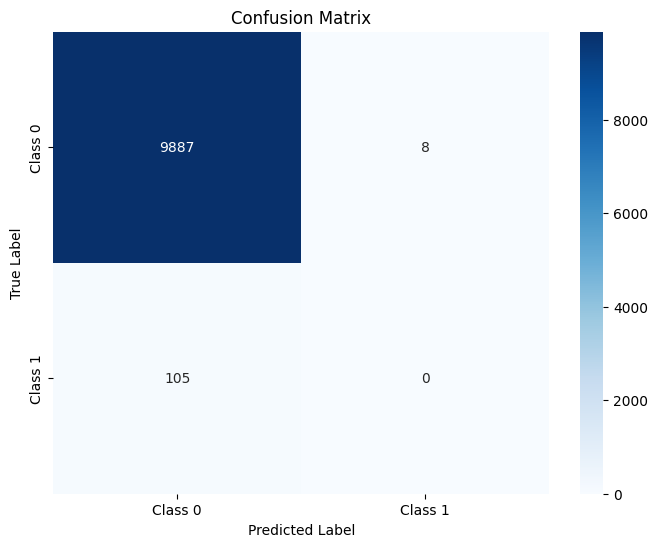

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
misclassified = synthetic_df[y_true != y_pred]
print("Misclassified Transactions:")
print(misclassified)

Misclassified Transactions:
          Time        V1         V2        V3        V4        V5        V6  \
55   -2.723139 -0.301091 -10.938181  0.028247 -1.005206 -2.173757  0.301311   
184   0.928589 -2.094713 -11.856466  1.139251  0.290849 -2.776463 -0.858314   
213  -3.898722 -2.406725  -7.746438 -0.902188  1.318074 -2.046650 -0.799934   
225  -1.297098  4.287657   0.377437  1.368621 -1.343542 -5.174131  1.822230   
523  -0.645420  2.244528   0.638881  0.488321  1.854590  4.638315 -6.299368   
...        ...       ...        ...       ...       ...       ...       ...   
9274 -4.035174 -1.396017  -5.757360 -1.224874  2.225145  0.818860 -0.271017   
9374  1.684379 -3.013360   4.330975  1.524783  1.409825  0.938711 -0.410171   
9388  0.774088 -0.259600  -2.630287 -0.695706 -1.545309 -1.496244 -1.933429   
9771 -5.883470 -4.344248  -7.932377  0.094940  3.075853  2.814499  1.258604   
9823 -2.497459 -0.804061  -4.422271  0.428184  0.551817  1.317948 -1.590958   

            V7        V

Creating synthetic data using SMOTE

In [36]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../data/creditcard.csv")

# Split features and target
X = df.drop('Class', axis=1)  # Features (exclude the target column)
y = df['Class']  # Target column

In [37]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Original dataset shape:", df['Class'].value_counts())
print("Resampled dataset shape:", pd.Series(y_resampled).value_counts())

Original dataset shape: Class
0    284315
1       492
Name: count, dtype: int64
Resampled dataset shape: Class
0    284315
1    284315
Name: count, dtype: int64


In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Load the dataset
df = pd.read_csv("../data/creditcard.csv")

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE for the minority class
smote = SMOTE(random_state=42)
X_smote_resampled, y_smote_resampled = smote.fit_resample(X_scaled, y)

# Balance the majority class by random undersampling
fraud_df = df[df['Class'] == 1]
non_fraud_df = df[df['Class'] == 0].sample(n=len(fraud_df), random_state=42)

balanced_df = pd.concat([fraud_df, non_fraud_df])

print("Balanced synthetic dataset class distribution:")
print(pd.Series(y_smote_resampled).value_counts())

Balanced synthetic dataset class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64


In [40]:
X_new = balanced_df.drop(columns=['Class'])  # Assuming 'Class' is the target
y_true = balanced_df['Class']

# Generate predictions
y_pred = model.predict(X_new)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Generate evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))
print("\nAccuracy Score:", accuracy_score(y_true, y_pred))

Confusion Matrix:
[[492   0]
 [ 22 470]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       492
           1       1.00      0.96      0.98       492

    accuracy                           0.98       984
   macro avg       0.98      0.98      0.98       984
weighted avg       0.98      0.98      0.98       984


Accuracy Score: 0.9776422764227642


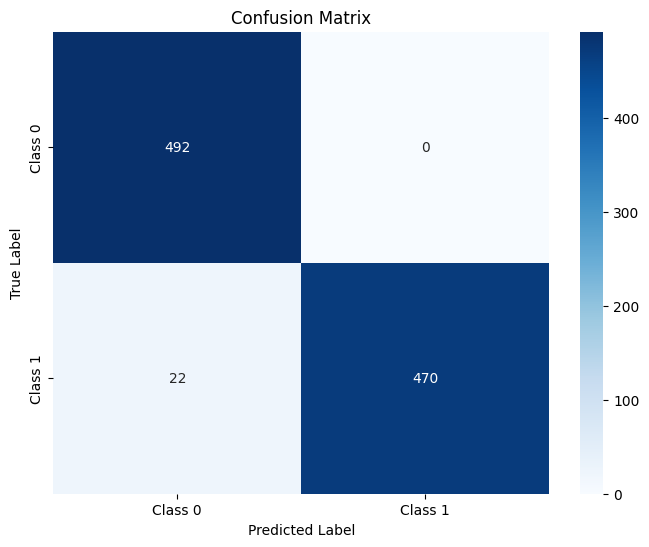

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [43]:
balanced_df.to_csv('../data/real_time_data.csv', index=False)

In [45]:
import pandas as pd

# Load the CSV file
csv_file_path = "../data/real_time_data.csv"
df = pd.read_csv(csv_file_path)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled data back to a CSV
shuffled_file_path = "../data/stream_real_time_data.csv"
df.to_csv(shuffled_file_path, index=False)

print(f"Shuffled data saved to: {shuffled_file_path}")

Shuffled data saved to: ../data/stream_real_time_data.csv
